In [ ]:
# Quick and dirty CNN to classify 

### imports

In [64]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop, Adadelta, Adam, SGD

In [2]:
%cd ..
import mrc

/Users/gw/repos/ece1512_project


### load in data
- use batches of few hundred to keep memory low

In [58]:
num=500
fname = '/Users/gw/Documents/education/2018w/ece1512/project/P11/J85/simulated_particles.mrcs'
particles_hires = mrc.read_imgs(fname,idx=0,num=num).swapaxes(0,1).swapaxes(0,2)

fname = '/Users/gw/Documents/education/2018w/ece1512/project/P11/J88/simulated_particles.mrcs'
particles_lowres = mrc.read_imgs(fname,idx=0,num=num).swapaxes(0,1).swapaxes(0,2)

stack = np.vstack([particles_hires,particles_lowres])

### Check if we can distinguish the resolution by eye

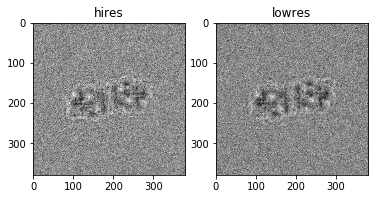

In [52]:
fig = plt.figure()
a = fig.add_subplot(121)
a.set_title('hires')
plt.imshow(stack[0],cmap='gray')

a = fig.add_subplot(122)
a.set_title('lowres')
plt.imshow(stack[-1],cmap='gray')

In [36]:
particles_hires.shape

(100, 380, 380)

In [73]:
o_x_train = stack
o_y_train = np.append(np.zeros(num),np.ones(num))
#np.random.shuffle(o_y_train) # garble labels to check if evaluation accuracy is 50%

In [74]:
x_train, x_val, y_train, y_val = train_test_split(o_x_train, o_y_train,
                                                  test_size=0.1,
                                                  random_state=20) # does random shuffle for us

y_train_targ = pd.get_dummies(y_train)
y_val_targ = pd.get_dummies(y_val)

x_train = x_train[:,:,:,np.newaxis]
x_val = x_val[:,:,:,np.newaxis]


print('The Training set images have this shape: ' + str(x_train.shape))
print('The Training set labels have this shape: ' + str(y_train_targ.shape))
print('The Validation set images have this shape: ' + str(x_val.shape))
print('The Validation set labels have this shape: ' + str(y_val_targ.shape))

The Training set images have this shape: (900, 380, 380, 1)
The Training set labels have this shape: (900, 2)
The Validation set images have this shape: (100, 380, 380, 1)
The Validation set labels have this shape: (100, 2)


### set up model
- this code came from a CNN used on mnist handwritten digits, of size $28^2$
- see the architecture in the Deep Consensus paper (Table 1 in doi:10.1107/S2052252518014392)
- try to get the number of training params to be ~1000s, so that the number of examples is an order of magnitude greater (~10k)

In [77]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

model = Sequential()
model.add(Conv2D(4, kernel_size=(3,3), input_shape=x_train.shape[1::], activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(4, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
n_classes = np.unique(o_y_train.tolist()).size
model.add(Dense(n_classes, activation='softmax'))

model.summary()

model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 378, 378, 4)       40        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 189, 189, 4)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 187, 187, 4)       148       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 93, 93, 4)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 34596)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                345970    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 22        
Total para

### fit and evaluate model

In [76]:
model.fit(x_train, y_train_targ.values, epochs=10, batch_size=int(x_train.shape[0]/100))


scores = model.evaluate(x_val, y_val_targ.values)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

Epoch 1/10
900/900 [==============================] - 21s 23ms/step - loss: 0.6644 - categorical_accuracy: 0.6322
Epoch 2/10
900/900 [==============================] - 21s 23ms/step - loss: 0.4780 - categorical_accuracy: 0.8344
Epoch 3/10
900/900 [==============================] - 22s 24ms/step - loss: 0.1419 - categorical_accuracy: 0.9900
Epoch 4/10
900/900 [==============================] - 22s 25ms/step - loss: 0.0236 - categorical_accuracy: 1.0000
Epoch 5/10
900/900 [==============================] - 21s 24ms/step - loss: 0.0099 - categorical_accuracy: 1.0000
Epoch 6/10
900/900 [==============================] - 21s 24ms/step - loss: 0.0057 - categorical_accuracy: 1.0000
Epoch 7/10
900/900 [==============================] - 21s 24ms/step - loss: 0.0039 - categorical_accuracy: 1.0000
Epoch 8/10
900/900 [==============================] - 21s 23ms/step - loss: 0.0029 - categorical_accuracy: 1.0000
Epoch 9/10
900/900 [==============================] - 21s 24ms/step - loss: 0.0023 - cat